In [207]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt

path_to_new_orders = 'new_order/'
new_orders_files = os.listdir(path_to_new_orders)

new_orders_df_list = [pd.read_csv(path_to_new_orders + file) for file in new_orders_files]
new_orders_df = pd.concat(new_orders_df_list) if len(new_orders_df_list) != 0 else None


orders = pd.read_csv(r'orders/orders_export_1.csv')

products = pd.read_csv(r'stock/products_export_1.csv')
products['fecha'] = dt.date(2022,4,28) 

In [208]:
product_important_columns = ['Handle', 'Title', 'Variant SKU', 'Published', 'Variant Inventory Qty', 'Variant Price', 'Cost per item', 'Status', 'fecha']
products[product_important_columns].head()

,Handle,Title,Variant SKU,Published,Variant Inventory Qty,Variant Price,Cost per item,Status,fecha
0,vitamina-c-serum-facial,Vitamina C - Serum facial,0,True,4,4200.0,NaN,active,2022-04-28
1,lips-glow,Lips Glow,1,True,1,2200.0,NaN,active,2022-04-28
2,lips-scrub,Lips Scrub,2,True,2,2200.0,NaN,active,2022-04-28
3,jabon-de-limpieza-intimo-prebiotico,Jabón de limpieza íntimo prebiótico,3,True,0,3000.0,NaN,active,2022-04-28
4,gel-lubricante-intimo,Gel lubricante íntimo,4,True,3,2500.0,NaN,active,2022-04-28


In [209]:
special_products = [
    'Kit Verano Crema',
    'Kit Día',
    'Kit Edad de Oro',
    'Rutina Noche',
    'Kit Unisex Noche',
    'Kit Completo Diario',
    'Rutina Día'
    'Kit Unisex Día',
    'Kit Diario + Protección',
    'Kit Verano Spray',
    'Kit Noche',
]


In [210]:
order_important_columns_for_stock = ['Name',  'Lineitem name', 'Lineitem quantity', 'Created at']
orders[order_important_columns_for_stock].head()
orders['Created at'] = pd.to_datetime(orders['Created at']).dt.tz_localize(None)

In [211]:
products = products[product_important_columns]
orders = orders[order_important_columns_for_stock]

In [212]:
movements = orders.merge(products[['Title', 'Variant SKU', 'Variant Inventory Qty', 'fecha']], left_on='Lineitem name', right_on='Title')
movements.drop(columns=['Lineitem name'], inplace=True)
movements.rename(columns={
    'Variant SKU': 'SKU', 'Lineitem quantity': 'quantity',
    'Variant Inventory Qty': 'stock', 'fecha': 'fecha_stock',
    'Created at': 'movement_date'}, inplace=True)
movements['SKU'] = movements['SKU'].str.split('-')
movements = movements.explode('SKU')
movements['movement_date'] = pd.to_datetime(movements['movement_date']).dt.tz_localize(None)
movements['fecha_stock'] = pd.to_datetime(movements['fecha_stock'])

movements.drop(columns='Title', inplace=True)
movements = movements.merge(products[['Title', 'Variant SKU']].rename(columns={'Variant SKU': 'SKU'}))

movements.head()

,Name,quantity,movement_date,SKU,stock,fecha_stock,Title
0,#1057,1,2022-04-28 06:10:50,27,6,2022-04-28,Espuma de Limpieza 3en1
1,#1052,1,2022-04-26 08:38:00,27,6,2022-04-28,Espuma de Limpieza 3en1
2,#1031,1,2022-04-08 17:43:49,27,6,2022-04-28,Espuma de Limpieza 3en1
3,#1026,1,2022-04-03 10:36:44,27,6,2022-04-28,Espuma de Limpieza 3en1
4,#1021,2,2021-12-26 11:01:46,27,6,2022-04-28,Espuma de Limpieza 3en1


# Get stock each Date

In [213]:
movements.sort_values(by='movement_date', inplace=True)
movements.head()

,Name,quantity,movement_date,SKU,stock,fecha_stock,Title
105,#1002,1,2021-02-27 20:46:28,28,4,2022-04-28,Bolsas y Ojeras. Antiage
76,#1002,1,2021-02-27 20:46:28,24,2,2022-04-28,Crema Antiage 360°
104,#1003,1,2021-02-27 23:15:36,28,4,2022-04-28,Bolsas y Ojeras. Antiage
35,#1004,1,2021-03-02 23:34:29,30,5,2022-04-28,Agua Micelar 3 en 1
103,#1005,1,2021-04-12 09:53:51,28,4,2022-04-28,Bolsas y Ojeras. Antiage


# Get demand Forecast

## At a Product level

In [214]:
orders.head()

,Name,Lineitem name,Lineitem quantity,Created at
0,#1057,Espuma de Limpieza 3en1,1,2022-04-28 06:10:50
1,#1057,Serum Redensity. COLÁGENO,1,2022-04-28 06:10:50
2,#1057,Kit Completo Diario,1,2022-04-28 06:10:50
3,#1056,Rutina Noche,1,2022-04-27 22:29:08
4,#1056,Kit Día,1,2022-04-27 22:29:08


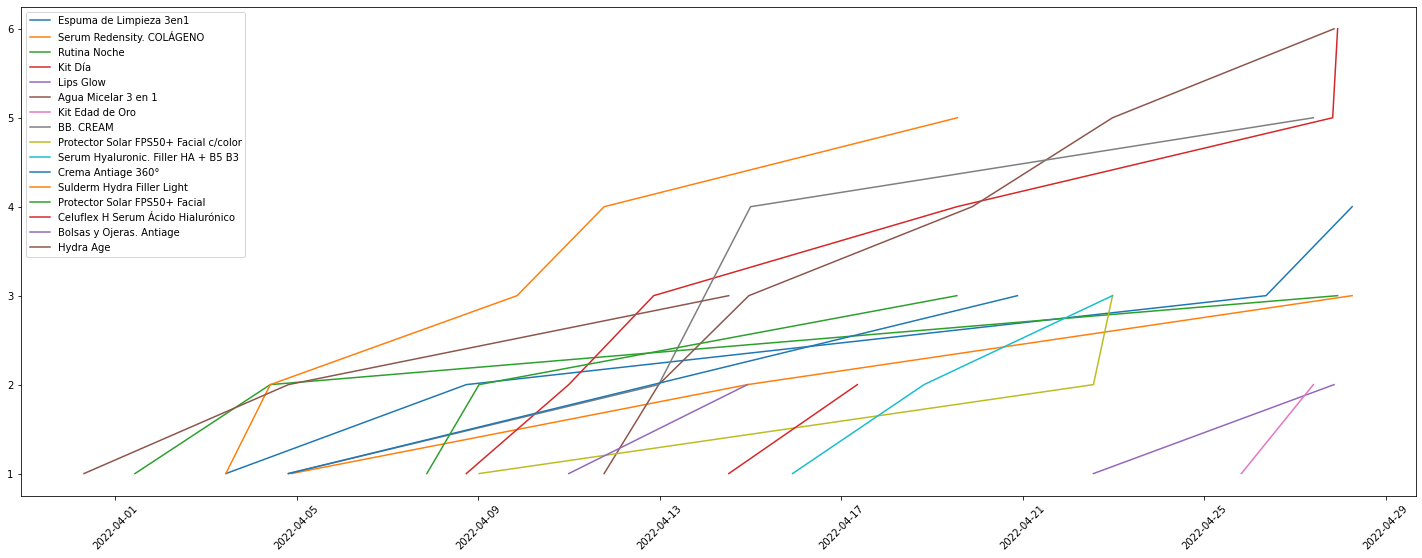

In [215]:
fig, ax = plt.subplots(figsize=(25,9))
for product in orders['Lineitem name'].unique():
    orders_of_produc_df = orders[orders['Lineitem name'] == product].sort_values(by='Created at')
    orders_of_produc_df = orders_of_produc_df[orders_of_produc_df['Created at'] > dt.datetime(2022,3,1)]
    orders_of_produc_df['cumsum_quantity'] = orders_of_produc_df['Lineitem quantity'].cumsum()
    if len(orders_of_produc_df) > 1:
        ax.plot(orders_of_produc_df['Created at'], orders_of_produc_df['cumsum_quantity'], label=product)
ax.legend()
plt.xticks(rotation = 45)
plt.show()

## At a SKU level

In [216]:
movements.head()

,Name,quantity,movement_date,SKU,stock,fecha_stock,Title
105,#1002,1,2021-02-27 20:46:28,28,4,2022-04-28,Bolsas y Ojeras. Antiage
76,#1002,1,2021-02-27 20:46:28,24,2,2022-04-28,Crema Antiage 360°
104,#1003,1,2021-02-27 23:15:36,28,4,2022-04-28,Bolsas y Ojeras. Antiage
35,#1004,1,2021-03-02 23:34:29,30,5,2022-04-28,Agua Micelar 3 en 1
103,#1005,1,2021-04-12 09:53:51,28,4,2022-04-28,Bolsas y Ojeras. Antiage


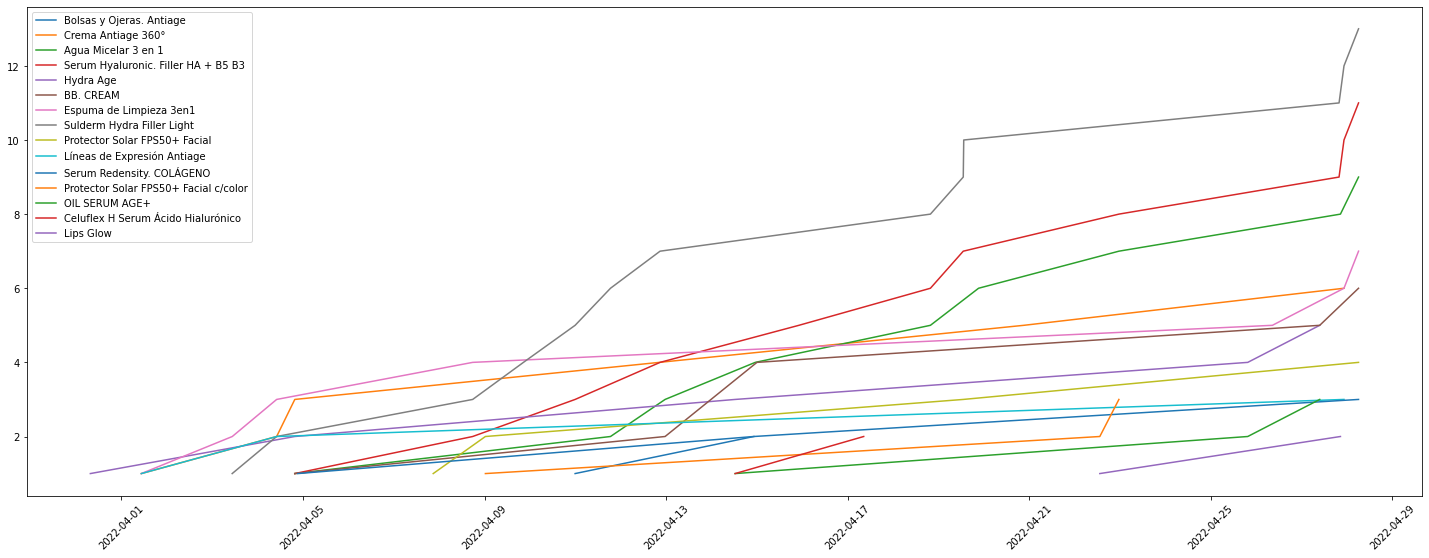

In [217]:
fig, ax = plt.subplots(figsize=(25,9))
for product in movements['Title'].unique():
    orders_of_produc_df = movements[movements['Title'] == product][['Title', 'movement_date', 'quantity']].groupby(['Title', 'movement_date']).sum().reset_index().sort_values(by='movement_date')
    orders_of_produc_df = orders_of_produc_df[orders_of_produc_df['movement_date'] > dt.datetime(2022,3,1)]
    orders_of_produc_df['cumsum_quantity'] = orders_of_produc_df['quantity'].cumsum()
    if len(orders_of_produc_df) > 1:
        ax.plot(orders_of_produc_df['movement_date'], orders_of_produc_df['cumsum_quantity'], label=product)
ax.legend()
plt.xticks(rotation = 45)
plt.show()

## Estimate average monthly demand

In [236]:
orders.head(2)

,Name,Lineitem name,Lineitem quantity,Created at
0,#1057,Espuma de Limpieza 3en1,1,2022-04-28 06:10:50
1,#1057,Serum Redensity. COLÁGENO,1,2022-04-28 06:10:50


In [237]:
monthly_demand = orders[orders['Created at'] > dt.datetime(2022,3,1)][['Lineitem name', 'Lineitem quantity']].groupby('Lineitem name').sum().reset_index()
monthly_demand.head()

,Lineitem name,Lineitem quantity
0,Agua Micelar 3 en 1,6
1,BB. CREAM,5
2,Bolsas y Ojeras. Antiage,2
3,CREMA HIDRATANTE CORPORAL SUPREME,1
4,Celuflex Dmae Estabilizador De La Membrana Cel...,1


In [238]:

monthly_demand_2 = monthly_demand.merge(products[['Title', 'Variant SKU']].rename(columns={'Variant SKU': 'SKU', 'Title': 'Lineitem name'}))
monthly_demand_2['SKU'] = monthly_demand_2['SKU'].str.split('-')
monthly_demand_2 = monthly_demand_2.explode('SKU')
monthly_demand_2.drop(columns='Lineitem name', inplace=True)

monthly_demand_2 = monthly_demand_2.merge(products[['Title', 'Variant SKU']].rename(columns={'Variant SKU': 'SKU'}))
monthly_demand_2 = monthly_demand_2.groupby(['SKU', 'Title']).sum().reset_index()
monthly_demand_2.rename(columns={'Lineitem quantity': 'monthly_demand'}, inplace=True)
monthly_demand_2.head(2)

,SKU,Title,monthly_demand
0,1,Lips Glow,2
1,10,CREMA HIDRATANTE CORPORAL SUPREME,1


In [239]:
products.head()

,Handle,Title,Variant SKU,Published,Variant Inventory Qty,Variant Price,Cost per item,Status,fecha
0,vitamina-c-serum-facial,Vitamina C - Serum facial,0,True,4,4200.0,NaN,active,2022-04-28
1,lips-glow,Lips Glow,1,True,1,2200.0,NaN,active,2022-04-28
2,lips-scrub,Lips Scrub,2,True,2,2200.0,NaN,active,2022-04-28
3,jabon-de-limpieza-intimo-prebiotico,Jabón de limpieza íntimo prebiótico,3,True,0,3000.0,NaN,active,2022-04-28
4,gel-lubricante-intimo,Gel lubricante íntimo,4,True,3,2500.0,NaN,active,2022-04-28


In [240]:
products_for_estimate_break = products[['Title', 'Variant SKU', 'Variant Inventory Qty']].rename(columns={'Variant Inventory Qty': 'stock'})
products_for_estimate_break.head(2)

,Title,Variant SKU,stock
0,Vitamina C - Serum facial,0,4
1,Lips Glow,1,1


In [241]:
products_for_estimate_break = products_for_estimate_break.rename(columns={'Variant SKU': 'SKU'}).merge(monthly_demand_2, on=['Title', 'SKU'])
products_for_estimate_break['stock_at_the_end_of_the_period'] = products_for_estimate_break['stock'] - products_for_estimate_break['monthly_demand']
products_for_estimate_break['amount_to_buy'] = np.where(products_for_estimate_break['stock_at_the_end_of_the_period']<0, -products_for_estimate_break['stock_at_the_end_of_the_period'], 0)

Title                             Lips GlowLips ScrubCrema humectante íntima pre...
SKU                                               125791012171920212224252627283031
stock                                                                            83
monthly_demand                                                                   83
stock_at_the_end_of_the_period                                                    0
amount_to_buy                                                                    15
dtype: object

,Title,SKU,stock,monthly_demand,amount_to_buy
18,Sulderm Hydra Filler Light,31,13,13,0
14,Serum Hyaluronic. Filler HA + B5 B3,26,12,11,0
17,Agua Micelar 3 en 1,30,5,9,4
15,Espuma de Limpieza 3en1,27,6,7,1
10,BB. CREAM,21,5,6,1
12,Crema Antiage 360°,24,2,6,4
11,Hydra Age,22,5,5,0
8,Protector Solar FPS50+ Facial,19,0,4,4
13,Líneas de Expresión Antiage,25,3,3,0
9,OIL SERUM AGE+,20,3,3,0


In [245]:
b = products_for_estimate_break.drop(columns='stock_at_the_end_of_the_period').sort_values(by='monthly_demand', ascending=False)
display(
    products_for_estimate_break.sum(),
    b,
    b[b['amount_to_buy']>0])

Title                             Lips GlowLips ScrubCrema humectante íntima pre...
SKU                                               125791012171920212224252627283031
stock                                                                            83
monthly_demand                                                                   83
stock_at_the_end_of_the_period                                                    0
amount_to_buy                                                                    15
dtype: object

,Title,SKU,stock,monthly_demand,amount_to_buy
18,Sulderm Hydra Filler Light,31,13,13,0
14,Serum Hyaluronic. Filler HA + B5 B3,26,12,11,0
17,Agua Micelar 3 en 1,30,5,9,4
15,Espuma de Limpieza 3en1,27,6,7,1
10,BB. CREAM,21,5,6,1
12,Crema Antiage 360°,24,2,6,4
11,Hydra Age,22,5,5,0
8,Protector Solar FPS50+ Facial,19,0,4,4
13,Líneas de Expresión Antiage,25,3,3,0
9,OIL SERUM AGE+,20,3,3,0


,Title,SKU,stock,monthly_demand,amount_to_buy
17,Agua Micelar 3 en 1,30,5,9,4
15,Espuma de Limpieza 3en1,27,6,7,1
10,BB. CREAM,21,5,6,1
12,Crema Antiage 360°,24,2,6,4
8,Protector Solar FPS50+ Facial,19,0,4,4
0,Lips Glow,1,1,2,1
